# Fig. 2
- This experiment tests whether the HD cells use landmark bearing or optic flow information, or both.
- The experiment start with open-loop presentaiton of flashes. Then, "sun-and-bars" scenes with smooth rotations are presented, which we use for the HD cell identification
- Next, the same scene is presented with abrupt jumps -- if the HD cells use landmark information, they should be able to track the scene across the jumps
- Finally, a featureless spatial noise pattern is presented, with smooth rotations -- if the HD cells can integrate rotational optic flow, they should still be able to follow the noise rotation 
- This notebook generates panels for **Fig. 2** as well as **Extended Data Fig. 1e, j, 5**.

In [33]:
from utility import *
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import flammkuchen as fl
from scipy.stats import wilcoxon, kstest, uniform
from scipy.signal import convolve2d
import json
from tqdm import tqdm
import colorcet as cc
from sklearn.linear_model import Ridge
from tqdm import tqdm

In [2]:
# configure matplotlib
config_rcparams()

In [8]:
# parameters
R2_thresh = 0.15  # for sinusoidal fit
flash_thresh = 0.1 # for rejecting flash responsive cells
n_heading_bin = 8 # binning HD cells
n_offset_bin = 16 # binning scene-bump offset
n_bootstrap = 1000 # #bootstrap shuffles
mask_name = 'rhombomere1'

local_r_hw = 7.5 # time window for calculating local correlation etc.
empty_bin_thresh = 5

In [6]:
# get a list of fish
fish_list = get_fish_list('../data/main02', silent=True)
nested_list = nest_fish_list_per_fish(fish_list)

# Analysis
## Data extraction and ROI selection

In [9]:
data = []

# Go through all unique fish
for fish_id, recording_list in enumerate(nested_list):
    data.append([])
    
    # Go through all recordings
    for recording in recording_list:
        
        # Load the latest mask
        mask_list = list(recording.glob('mask_'+mask_name+'*'))
        with open(mask_list[-1], 'r') as f:
            mask = json.load(f)
        
        #################
        ### Load data ###
        #################

        # load behavioral & imaging data
        s2p_data, t_i, exp = load_data(recording, cells_only=False)
        
        # pull out relevant piece of data from dict
        roi_coords = s2p_data['coords']
        slog = exp['stimulus']['log']
        t_s = exp.stimulus_log['t'].to_numpy()

        # separate scene orientation into ex- and re-afferent components
        theta = exp.stimulus_log['cl2D_theta'].to_numpy()
        gtheta = exp.stimulus_log['cl2D_goal_theta'].to_numpy()
        ftheta = exp.stimulus_log['cl2D_fish_theta'].to_numpy() * exp.stimulus_log['cl2D_start_theta_update'].to_numpy()
        ftheta[np.isnan(ftheta)] = 0

        # downsample to imaging timestamps
        theta_i = downsample_traces(t_s, theta, t_i)
        cumftheta_i = downsample_traces(t_s, np.cumsum(ftheta), t_i)
        extheta_i = downsample_traces(t_s, gtheta+np.cumsum(ftheta), t_i)
        
        # restrict rois by mask (do this before functional selection to reduce the time-consuming nonlinear curve fitting)
        in_mask = (roi_coords[:, 2] > mask['x0']) * (roi_coords[:, 2] < mask['x1']) * (roi_coords[:, 1] > mask['y0']) * (roi_coords[:, 1] < mask['y1'])
        traces = s2p_data['traces'][in_mask,:len(t_i)]
        roi_coords = roi_coords[in_mask, :]
        n_roi = traces.shape[0]

        # normalization and smoothing
        norm_traces = ((traces.T - np.median(traces, axis=1))/np.std(traces, axis=1)).T
        smoothed_traces = convolve2d(norm_traces, np.ones((1,5))/5, mode='same')
        
        #####################
        ### ROI selection ###
        #####################
        
        # Flash
        flash_duration = slog[1]['duration']*2
        flash_t_start = [epoch['t_start'] for epoch in slog[1:-2:2]] # first epoch is wait, last two epochs are sun-and-bars and darkness. 
        flash_corr = calc_snip_correlation(norm_traces, t_i, flash_t_start, flash_duration)
        
        # Sinusoidal regression
        is_valid_theta = (np.isnan(theta_i)==False) * (t_i < slog[-2]['t_start']) # use the only smooth epoch
        fit_param, _, R2 = fit_transform_sinusoid(smoothed_traces[:, is_valid_theta], theta_i[is_valid_theta])
        
        # do the selection
        good_fit = (R2 > R2_thresh) * (flash_corr < flash_thresh)
        print(recording, 'Found', np.sum(good_fit), 'good ROIs out of', n_roi)
        
        # metadata for variability analysis
        metadata_dict = {'age': exp['general']['animal']['age'],
                         'n_roi_tot':traces.shape[0],
                         'hour':int(exp['general']['t_protocol_start'][11:13]),
                         'n_bout_tot':len(np.where(exp.stimulus_log['cl2D_start_theta_update'])[0])}
        
        ### Save everything in a dictionary ###
        D = {'stack': s2p_data['anatomy_stack'][0,:,:],
             'slog': slog,
             't_s': t_s,
             't_b': exp.behavior_log['t'].to_numpy(),
             'fish_theta': exp.stimulus_log['cl2D_fish_theta'].to_numpy(),
             'theta_update_spike': exp.stimulus_log['cl2D_start_theta_update'].to_numpy(),
             'tail_sum': exp.behavior_log['tail_sum'].to_numpy(),
             't_i': t_i,
             'theta_i': theta_i,
             'cumftheta_i': cumftheta_i,
             'extheta_i': extheta_i,
             'traces': smoothed_traces[good_fit, :],
             'fit_param': fit_param[good_fit,:],
             'coords': roi_coords[good_fit, :],
             'metadata':metadata_dict}
        data[-1].append(D)

..\data\main02\20230905_f2_p0_noisy_copy Found 72 good ROIs out of 200
..\data\main02\20230905_f2_p1_noisy Found 23 good ROIs out of 510
..\data\main02\20230905_f3_p0_noisy Found 16 good ROIs out of 195
..\data\main02\20230905_f3_p1_noisy Found 41 good ROIs out of 350
..\data\main02\20231018_f0_p0_v06 Found 36 good ROIs out of 128
..\data\main02\20231018_f1_p0_v06 Found 36 good ROIs out of 109
..\data\main02\20231026_f0_86_6 Found 34 good ROIs out of 85
..\data\main02\20231026_f3_6 Found 24 good ROIs out of 159
..\data\main02\20231026_f5_6_copy Found 23 good ROIs out of 167
..\data\main02\20231026_f7_v6 Found 6 good ROIs out of 153
..\data\main02\20231105_f0_gad1b_aHB_z273_postdrift_v6 Found 2 good ROIs out of 89
..\data\main02\20231105_f1_gad1b_aHB_z155_6 Found 61 good ROIs out of 97
..\data\main02\20231105_f3_gad1b_ahb_z190 Found 9 good ROIs out of 145
..\data\main02\20231107_f0_gad1b_ahb_z280_v6 Found 22 good ROIs out of 165
..\data\main02\20231107_f0_gad1b_ahb_z300_v6 Found 43 good

## Additional preprocessing
- Calculate bump phaes
- Remove fish with an insufficient number of bins filled

In [10]:
bad_recs = []
for i, fish_data in enumerate(data):
    for j, D in enumerate(fish_data):
        # bump phase calculation
        pva_theta, pva_length, binned_traces, _, _ = calc_binned_pva(D['traces'], D['fit_param'][:,1], n_bin=n_heading_bin)

        # bin check
        n_empty_bins = np.sum(np.isnan(binned_traces[:,0]))
        
        if n_empty_bins < empty_bin_thresh:        
            data[i][j]['pva_theta'] = pva_theta
            data[i][j]['pva_length'] = pva_length
            data[i][j]['binned_traces'] = binned_traces
        else:
            bad_recs.append((i,j))

# pop bad recs from big ones
for i, j in bad_recs[::-1]:
    print('popping fish {} rec {}'.format(i,j))
    data[i].pop(j)
data = [fish for fish in data if fish]

popping fish 10 rec 0
popping fish 8 rec 0
popping fish 7 rec 0


## Offset histogram calculation, von Mises fit, and Bootstrap testing (of $\kappa$)
- will take a couple minutes

In [11]:
# binning parameter - used as the x axis for visualization as well
offset_bin_edges = np.linspace(-np.pi, np.pi, n_offset_bin+1)
offset_bin_center = (offset_bin_edges[:-1] + offset_bin_edges[1:])/2

# go though fish & recordings
for i, fish_data in enumerate(data):
    for j, D in enumerate(fish_data):
        
        # Fit von Mises distribution to the offset between the bump and scene orientation
        # separately for jump and noise
        bump_scene_offset = angular_diff(D['theta_i'], D['pva_theta'])
        is_jump  = (D['t_i']>D['slog'][-2]['t_start']) * (D['t_i']<D['slog'][-1]['t_start'])
        is_noise = D['t_i']>D['slog'][-1]['t_start']
        
        j_hist = np.histogram(bump_scene_offset[is_jump], bins=offset_bin_edges, density=True)[0]
        n_hist = np.histogram(bump_scene_offset[is_noise], bins=offset_bin_edges, density=True)[0]
        
        j_fit, _ = curve_fit(von_Mises, offset_bin_center, j_hist, bounds=([-np.pi,0], [np.pi,np.inf]))
        n_fit, _ = curve_fit(von_Mises, offset_bin_center, n_hist, bounds=([-np.pi,0], [np.pi,np.inf]))

        shuffle_kappa = np.zeros((n_bootstrap, 2))
        for b in tqdm(range(n_bootstrap)):
            # shift theta and bump by a random amount, recalculate offset, fit von Mises again
            j_shuffled_offset = angular_diff(D['theta_i'][is_jump], np.roll(D['pva_theta'][is_jump], np.random.randint(np.sum(is_jump))))
            n_shuffled_offset = angular_diff(D['theta_i'][is_noise], np.roll(D['pva_theta'][is_noise], np.random.randint(np.sum(is_noise))))

            j_shuffled_hist = np.histogram(j_shuffled_offset, bins=offset_bin_edges, density=True)[0]
            n_shuffled_hist = np.histogram(n_shuffled_offset, bins=offset_bin_edges, density=True)[0]
            
            j_shuffled_fit, _ = curve_fit(von_Mises, offset_bin_center, j_shuffled_hist, bounds=([-np.pi,0], [np.pi,np.inf]))
            n_shuffled_fit, _ = curve_fit(von_Mises, offset_bin_center, n_shuffled_hist, bounds=([-np.pi,0], [np.pi,np.inf]))
            
            shuffle_kappa[b,0] = j_shuffled_fit[1]
            shuffle_kappa[b,1] = n_shuffled_fit[1]
            
        data[i][j]['offset_hist'] = (j_hist, n_hist)
        data[i][j]['fit_mu'] = (j_fit[0], n_fit[0])
        data[i][j]['fit_kappa'] = (j_fit[1], n_fit[1])
        data[i][j]['bs_med_kappa'] = np.median(shuffle_kappa, axis=0)
        data[i][j]['bs_95pt_kappa'] = np.percentile(shuffle_kappa, 95, axis=0)
        data[i][j]['p_kappa'] = np.mean(shuffle_kappa > data[i][j]['fit_kappa'], axis=0) # didn't know I can do auto-unsqueezed comparison between 2d array vs. tuple!

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 62.90it/s]


## Local correlation & bootstrap
- Pull out snippets of bump movements centered around exogenous rotation (for noise epoch)
- Calculate correlation between theta and bump phase
- Do the same thing with time-domain shuffle

In [12]:
for i, fish_data in enumerate(data):
    for j, D in enumerate(fish_data):
        
        # to simplify rolling for bootstrapping, we first curtail all the time traces (limit to the noise epoch)
        is_noise = (D['t_i']>D['slog'][-1]['t_start']) * (~np.isnan(D['theta_i']))
        t_i = D['t_i'][is_noise]
        theta_i = D['theta_i'][is_noise]
        pva_theta = D['pva_theta'][is_noise]
                               
        # Rotations happen during the last 5 second of every 30 seconds 
        # we would calculate correlation within local period centered about the rotations
        t_noise_rotation_midpoint = np.arange(min(t_i), max(t_i), 30) + 27.5
        # make sure that the window for correlation calciulation is all within the epoch
        t_noise_rotation_midpoint = np.asarray([t for t in t_noise_rotation_midpoint if min(t_i)+local_r_hw < t < max(t_i)-local_r_hw])
        
        r_local = chuncked_correlation(t_i, theta_i, np.unwrap(pva_theta), t_noise_rotation_midpoint, local_r_hw, local_r_hw)
        med_r_local = np.median(r_local) # doing median, because sample size small and there can be outliers we don't believe due to unwrapping issues
        
        # Do the bootstrapping
        bs_med_r_local = np.zeros(n_bootstrap)
        for b in tqdm(range(n_bootstrap)):
            # roll by a random amount
            shift_amount = np.random.randint(len(t_i))
            rolled_theta_i = np.roll(theta_i, shift_amount)
            # need to remove the local period containing the discontinuity due to the shuffling
            discontinuous_point = t_i[shift_amount]
            is_discontinuous = np.abs(t_noise_rotation_midpoint - discontinuous_point) < local_r_hw
            bs_r_local = chuncked_correlation(t_i, rolled_theta_i, np.unwrap(pva_theta), t_noise_rotation_midpoint[~is_discontinuous], local_r_hw, local_r_hw)
            bs_med_r_local[b] = np.nanmedian(bs_r_local) # this can be nan, because theta can remain unchanged

        
        data[i][j]['r_local'] = med_r_local
        data[i][j]['bs_med_r_local'] = np.median(bs_med_r_local)
        data[i][j]['bs_95pt_r_local'] = np.percentile(bs_med_r_local, 95)
        data[i][j]['p_r'] = np.mean(bs_med_r_local > med_r_local, axis=0)


  0%|                                                                                                                                                        | 0/1000 [00:00<?, ?it/s]C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 506.55it/s]


# Panels
## Fig. 2d (individual example -- behavior + neural traces)

In [13]:
# pick a single fish
fid = 4
rid = 0
D = data[fid][rid]

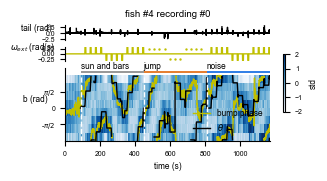

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(3.3,1.5), height_ratios=(1,1,5))

## Behavioral time trace
ax[0].plot(D['t_b'], D['tail_sum'], label='tail sum', color='black')
ax[0].set_title('fish #{0} recording #{1}'.format(fid,rid))
ax[0].set_ylabel('tail (rad)', rotation=0)
toggle_spines(ax[0],0,0,0,1)

## visualize external rotation (show jumps as dots)
t_start = D['slog'][-3]['t_start']
t_jump = D['slog'][-2]['t_start']
t_noise = D['slog'][-1]['t_start']
t_end = max(D['t_i'])

OL_on = (((D['t_i']-t_start)%30)>25) * (D['t_i']>t_start) * (D['t_i']<t_jump) +\
        (((D['t_i']-t_noise)%30)>25) * (D['t_i']>t_noise) 
OL_sign = 1-2*(((D['t_i']-t_start)%240)>120)
jumps = np.arange(t_jump+30, t_noise, 30)
jump_sign = 1-2*(((jumps-t_jump)%240)>120)

ax[1].plot(D['t_i'], OL_on*OL_sign*18/180*np.pi,'y-')
ax[1].scatter(jumps, 0.25*jump_sign, color='y', marker='.', s=2)
ax[1].set_ylabel(r'$\omega_{ext}$ (rad/s)',rotation=0)
toggle_spines(ax[1],0,0,0,1)

## Neural time trace
im = ax[2].imshow(D['binned_traces'][::-1, :], aspect='auto', interpolation='nearest', vmax=2, vmin=-2, extent=(0, max(D['t_i']), -np.pi, np.pi), cmap='Blues')
ax[2].plot(D['t_i'], wrapped(np.unwrap(D['pva_theta']), offset=np.pi), 'y-', label='bump phase', lw=1.0)
ax[2].plot(D['t_i'], wrapped(D['theta_i'], offset=np.pi), 'k-',label=r'$\theta$', lw=1.0)
ax[2].legend()

# annotate epochs
for i, cname in zip((-3,-2,-1), ('sun and bars','jump','noise')):
    this_start = D['slog'][i]['t_start'] 
    this_end = this_start + D['slog'][i]['duration']
    ax[2].plot((this_start, this_start),(-np.pi,np.pi),'w--')
    ax[2].fill_between((this_start, this_end), (np.pi+0.2, np.pi+0.2), (np.pi+0.4, np.pi+0.4), facecolor=color_getter(i+4), edgecolor='none')
    ax[2].text(this_start, np.pi+0.6, cname)

ax[2].set_yticks([-np.pi/2, 0, np.pi/2])
ax[2].set_yticklabels((r'-$\pi/2$', '0', r'$\pi/2$'))
ax[2].set_ylabel('b (rad)', rotation=0)

ax[2].set_xlabel('time (s)')
cb = plt.colorbar(im, ax=ax, shrink=0.5)
cb.set_label('std')

toggle_spines(ax[2],0,1,0,1)
for axx in ax:
    axx.set_xlim(0, t_end)

plt.savefig('../svg/main02_d.svg')
plt.show()

## Fig. 2e (histogram of bump-scene offsets with von Mises fit)

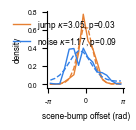

In [16]:
# show histogram with fit
fig, ax = plt.subplots(1, 1, figsize=(1,1))
cnames = ('jump','noise')

for i in range(2):
    ax.plot(offset_bin_center, D['offset_hist'][i], color=color_getter(i+2), label=cnames[i]+' $\kappa$={:0.2f}, p={:0.2f}'.format(D['fit_kappa'][i], D['p_kappa'][i]))
    ax.plot(offset_bin_center, von_Mises(offset_bin_center, D['fit_mu'][i], D['fit_kappa'][i]), ls='--', color=color_getter(i+2))
ax.legend()

# axis management
ax.set_xlabel('scene-bump offset (rad)')
ax.set_ylabel('density')
ax.set_xticks([-np.pi, 0, np.pi])
ax.set_xticklabels((r'-$\pi$', '0', r'$\pi$'))
ax.set_xlabel('scene-bump offset (rad)')
toggle_spines(ax, 0, 1, 0, 1)

plt.savefig('../svg/main02_e.svg')
plt.show()

## Fig. 2f (population von Mises $\kappa$ with bootstrap distributions)

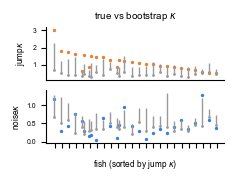

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(2.3, 1.5))

# first, sort data by max jump kappa
sort_ind = np.argsort([-np.max([D['fit_kappa'][0] for D in fish_data]) for fish_data in data])

all_kappa = [np.asarray([D['fit_kappa'] for D in fish_data]) for fish_data in data]
all_bs_med_kappa = [np.asarray([D['bs_med_kappa'] for D in fish_data]) for fish_data in data]
all_bs_95pt_kappa = [np.asarray([D['bs_95pt_kappa'] for D in fish_data]) for fish_data in data]

# go through all the fish -- do scatter with some spread
for j, i in enumerate(sort_ind):
    fish_data = data[i]
    n_rec = len(fish_data)
    x_spread = np.linspace(-0.1, 0.1, n_rec) + j
    
    for k in range(2):
        ax[k].scatter(x_spread, all_kappa[i][:, k], s=2, color=color_getter(k+2))
        ax[k].errorbar(x_spread, all_bs_med_kappa[i][:,k],
                       np.vstack((all_bs_med_kappa[i][:,k]*0, all_bs_95pt_kappa[i][:,k]-all_bs_med_kappa[i][:,k])),
                       marker='.', color=color_getter(1), linestyle='none', markersize=2)

# cosmetics
ax[1].set_xticks(range(len(data)))
ax[1].set_xlabel('fish (sorted by jump $\kappa$)')
ax[0].set_title('true vs bootstrap $\kappa$')
ax[0].set_xticks([])
ax[1].set_xticklabels([])
for axx, cname in zip(ax,cnames):
    toggle_spines(axx, 0, 1, 0, 1)
    axx.set_ylabel(cname+'$\kappa$')

plt.savefig('../svg/main02_f.svg')
plt.show()

## Fig. 2h (local correlation with bootstrap distributions)

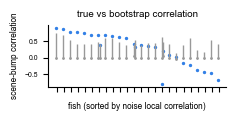

In [19]:
# local correlation
fig, ax = plt.subplots(1, 1, figsize=(2.3, 0.8))

# first, sort data by local correlation
sort_ind = np.argsort([-np.max([D['r_local'] for D in fish_data]) for fish_data in data])

all_r = [np.asarray([D['r_local'] for D in fish_data]) for fish_data in data]
all_bs_med_r = [np.asarray([D['bs_med_r_local'] for D in fish_data]) for fish_data in data]
all_bs_95pt_r = [np.asarray([D['bs_95pt_r_local'] for D in fish_data]) for fish_data in data]

# go through all the fish -- do scatter with some spread
for j, i in enumerate(sort_ind):
    fish_data = data[i]
    n_rec = len(fish_data)
    x_spread = np.linspace(-0.1, 0.1, n_rec) + j
    
    ax.scatter(x_spread, all_r[i], s=2, color=color_getter(3))
    ax.errorbar(x_spread, all_bs_med_r[i],
                np.vstack((all_bs_med_r[i]*0, all_bs_95pt_r[i]-all_bs_med_r[i])),
                marker='.', color=color_getter(1), linestyle='none', markersize=2)

# cosmetics
ax.set_xticks(range(len(data)))
ax.set_xticklabels([])
ax.set_xlabel('fish (sorted by noise local correlation)')
ax.set_title('true vs bootstrap correlation')
ax.set_ylabel('scene-bump correlation')
toggle_spines(ax, 0, 1, 0, 1)

plt.savefig('../svg/main02_h.svg')
plt.show()

In [20]:
# print stats
print('#fish = ',len(data))
print('#recordings = ',np.sum([len(fishdata) for fishdata in data]))

kappa_sig = [[D['fit_kappa'] > D['bs_95pt_kappa'] for D in fd] for fd in data]
r_sig = [[D['r_local'] > D['bs_95pt_r_local'] for D in fd] for fd in data]

n_fish_kappa_sig = np.sum([np.any(np.vstack(ks),axis=0) for ks in kappa_sig], axis=0)
n_fish_r_sig = np.sum([np.any(r) for r in r_sig])

print('#fish significant kappa jump {} noise {}'.format(*n_fish_kappa_sig))
print('#fish significant local correlation noise {}'.format(n_fish_r_sig))

#fish =  24
#recordings =  27
#fish significant kappa jump 15 noise 3
#fish significant local correlation noise 11


## Extended Data Fig. 5a (additional individual examples)

In [21]:
# pick recordings to show
fids = (3, 14, 9, 16)
rids = (0, 0, 0, 0)

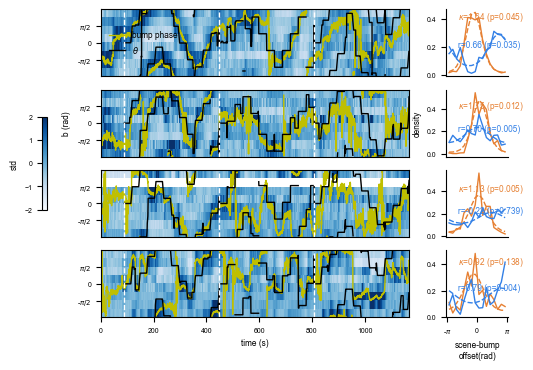

In [24]:
fig, ax = plt.subplots(len(fids), 2, figsize=(7, 1 * len(fids)), width_ratios=(5,1))

p_kappa = [np.asarray([D['p_kappa'][0] for D in fish_data]) for fish_data in data]
p_r     = [np.asarray([D['p_r'] for D in fish_data]) for fish_data in data]

for fid, rid, axx in zip(fids, rids, ax):
    D = data[fid][0]
    
    t_start = D['slog'][-3]['t_start']
    t_jump  = D['slog'][-2]['t_start']
    t_noise = D['slog'][-1]['t_start']
    
    # traces
    im = axx[0].imshow(D['binned_traces'][::-1, :], aspect='auto', interpolation='nearest', vmax=2, vmin=-2, extent=(0, max(D['t_i']), -np.pi, np.pi), cmap='Blues')
    axx[0].plot(D['t_i'], wrapped(np.unwrap(D['pva_theta']), offset=np.pi), 'y-',  label='bump phase')
    axx[0].plot(D['t_i'], wrapped(D['theta_i'], offset=np.pi), 'k-', label=r'$\theta$')
    axx[0].plot((t_start,t_start),(-np.pi,np.pi),'w--')
    axx[0].plot((t_jump,t_jump),(-np.pi,np.pi),'w--')
    axx[0].plot((t_noise,t_noise),(-np.pi,np.pi),'w--')
    axx[0].set_yticks([-np.pi/2, 0, np.pi/2])
    axx[0].set_yticklabels((r'-$\pi/2$', '0', r'$\pi/2$'))
    

    # histogram with fits
    for i in range(2):
        axx[1].plot(offset_bin_center, D['offset_hist'][i], color=color_getter(i+2), label=cnames[i]+' $\kappa$={:0.2f}'.format(D['fit_kappa'][i]))
        axx[1].plot(offset_bin_center, von_Mises(offset_bin_center, D['fit_mu'][i], D['fit_kappa'][i]), ls='--', color=color_getter(i+2))
    axx[1].text(-2,0.4,"$\kappa$={:0.2f} (p={:0.3f})".format(all_kappa[fid][rid][0], p_kappa[fid][rid]), color=color_getter(2))
    axx[1].text(-2,0.2,"r={:0.2f} (p={:0.3f})".format(all_r[fid][rid], p_r[fid][rid]), color=color_getter(3))
    
    k=k+1
    
cb = plt.colorbar(im, ax=ax, shrink=0.3, location='left')
cb.set_label('std')

ax[0, 0].legend()
ax[1, 0].set_ylabel('b (rad)')
ax[1, 1].set_ylabel('density')
ax[-1, 0].set_xlabel('time (s)')
ax[-1, 1].set_xlabel('scene-bump\noffset(rad)')
ax[-1, 1].set_xticks([-np.pi, 0, np.pi])
ax[-1, 1].set_xticklabels((r'-$\pi$', '0', r'$\pi$'))

# cosmetics
for i, axx in enumerate(ax):
    toggle_spines(axx[1],0,1,0,1)
    if i<len(fids)-1:
        axx[0].set_xticks([])
        axx[1].set_xticks([])

plt.savefig('../svg/ed05_a.svg')
plt.show()

## Extended Data Fig. 5b (compare jump epoch $\kappa$ with noise epoch local correlation)

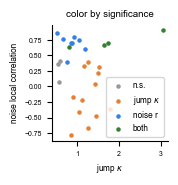

In [25]:
# color by significance
sig_kappa = flatten_list_of_array(p_kappa) <= 0.05
sig_r = flatten_list_of_array(p_r) <= 0.05
rec_type = sig_kappa.astype(int) + 2 * sig_r.astype(int)

fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))
labels = ('n.s.','jump $\kappa$','noise r','both')
for i in range(4):
    this_type = (rec_type)==i
    ax.scatter(flatten_list_of_array(all_kappa)[this_type,0],
               flatten_list_of_array(all_r)[this_type],
               color=color_getter(i+1), label=labels[i],s=5)
    
ax.set_xlabel('jump $\kappa$')
ax.set_ylabel('noise local correlation')
ax.set_title('color by significance')
toggle_spines(ax, 0,1,0,1)
plt.legend(frameon=True)

plt.savefig('../svg/ed05_b.svg')
plt.show()

In [27]:
temp = [print(l+'={} '.format((np.sum(rec_type==i)))) for i, l in enumerate(labels)]

n.s.=3 
jump $\kappa$=12 
noise r=8 
both=4 


## Extended Data Fig. 5c (cumulative distributions of the bootstrap p-values)

In [29]:
# flatten p-values
p_kappa_jump  = [[D['p_kappa'][0]  for D in fd] for fd in data]
p_kappa_noise = [[D['p_kappa'][1]  for D in fd] for fd in data]
p_r = [[D['p_r'] for D in fd] for fd in data]

In [31]:
flattened_pkj = []
flattened_pkn = []
flattened_pr = []

temp = [flattened_pkj.extend(x) for x in p_kappa_jump]
temp = [flattened_pkn.extend(x) for x in p_kappa_noise]
temp = [flattened_pr.extend(x) for x in p_r]

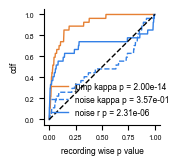

In [34]:
# calculate cdf
p_x = np.linspace(0,1,1000)
pkj_cdf = np.asarray([np.mean(flattened_pkj<x) for x in p_x])
pkn_cdf = np.asarray([np.mean(flattened_pkn<x) for x in p_x])
pr_cdf = np.asarray([np.mean(flattened_pr<x) for x in p_x])

# do KS tests
ksp_pkj = kstest(flattened_pkj, uniform.cdf)[1]
ksp_pkn = kstest(flattened_pkn, uniform.cdf)[1]
ksp_pr = kstest(flattened_pr, uniform.cdf)[1]

# plot
fig, ax = plt.subplots(1,1,figsize=(1.5, 1.5))
ax.plot(p_x, pkj_cdf, color=color_getter(2), label='jump kappa p = {:0.2e}'.format(ksp_pkj))
ax.plot(p_x, pkn_cdf, '--', color=color_getter(3), label='noise kappa p = {:0.2e}'.format(ksp_pkn))
ax.plot(p_x, pr_cdf, color=color_getter(3), label='noise r p = {:0.2e}'.format(ksp_pr))
ax.plot((0,1), (0,1), 'k--')

ax.set_xlabel('recording wise p value')
ax.set_ylabel('cdf')
ax.legend()
toggle_spines(ax, 0, 1, 0, 1)

plt.savefig('../svg/ed05_c.svg')
plt.show()

## Extended Data Fig. 1j (covariance with nuiscance vairables)

In [35]:
# disregard nesting (for the sake of simplicity)
flat_kappa = flatten_list_of_array([np.asarray([D['fit_kappa'] for D in fish_data]) for fish_data in data])
flat_r = flatten_list_of_array([np.asarray([D['r_local'] for D in fish_data]) for fish_data in data])

ages = []
hours = []
n_rois = []
n_bouts = []
    
for rec in data:
    for D in rec:
        ages.append(D['metadata']['age'])
        hours.append(D['metadata']['hour'])
        n_rois.append(D['metadata']['n_roi_tot'])
        n_bouts.append(D['metadata']['n_bout_tot'])

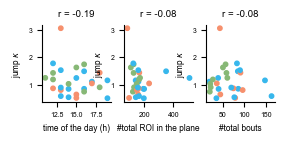

In [36]:
# for jump phase kappa

fig, ax = plt.subplots(1, 3, figsize=(3,1))

ax[0].scatter(hours, flat_kappa[:,0], c=ages, s=10, cmap=cc.cm.CET_I1)
ax[0].set_xlabel('time of the day (h)')
ax[0].set_title('r = {:0.2f}'.format(np.corrcoef(hours, flat_kappa[:,0])[0,1]))

ax[1].scatter(n_rois,  flat_kappa[:,0], c=ages, s=10, cmap=cc.cm.CET_I1)
ax[1].set_xlabel('#total ROI in the plane')
ax[1].set_title('r = {:0.2f}'.format(np.corrcoef(n_rois, flat_kappa[:,0])[0,1]))

ax[2].scatter(n_bouts, flat_kappa[:,0], c=ages, s=10, cmap=cc.cm.CET_I1)
ax[2].set_xlabel('#total bouts')
ax[2].set_title('r = {:0.2f}'.format(np.corrcoef(n_bouts, flat_kappa[:,0])[0,1]))

for axx in ax:
    toggle_spines(axx, 0, 1, 0, 1)
    axx.set_ylabel('jump $\kappa$')

plt.savefig('../svg/ed01_j1.svg')
plt.show()

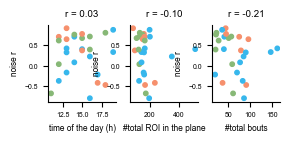

In [37]:
# for noise phase local correlation

fig, ax = plt.subplots(1, 3, figsize=(3,1))

ax[0].scatter(hours, flat_r, c=ages, s=10, cmap=cc.cm.CET_I1)
ax[0].set_xlabel('time of the day (h)')
ax[0].set_title('r = {:0.2f}'.format(np.corrcoef(hours, flat_r)[0,1]))

ax[1].scatter(n_rois,  flat_r, c=ages, s=10, cmap=cc.cm.CET_I1)
ax[1].set_xlabel('#total ROI in the plane')
ax[1].set_title('r = {:0.2f}'.format(np.corrcoef(n_rois, flat_r)[0,1]))

ax[2].scatter(n_bouts, flat_r, c=ages, s=10, cmap=cc.cm.CET_I1)
ax[2].set_xlabel('#total bouts')
ax[2].set_title('r = {:0.2f}'.format(np.corrcoef(n_bouts, flat_r)[0,1]))

for axx in ax:
    toggle_spines(axx, 0, 1, 0, 1)
    axx.set_ylabel('noise r')
    
plt.savefig('../svg/ed01_j2.svg')
plt.show()

## Extended Data Fig. 1e (turning around the external scene rotation)

In [39]:
# Cut out snippets of exafferent rotation & cumulative turns

mean_snips = []

for i, fish_data in enumerate(data):
    
    this_fish_theta_snips = []
    this_fish_cumftheta_snips = []
    this_fish_extheta_snips = []
    
    D = fish_data[0] # using the fact that this experiment was never repeated twice in the same fish
    
    mean_snips.append([[],[],[]])
    for k in (-3, -2, -1): # for sun and bars / jump / noise
        # find midpoints of exafferent rotations
        t_start = D['slog'][k]['t_start']
        duration = D['slog'][k]['duration']
        olp = D['slog'][k]['OLperiod']
        old = D['slog'][k]['OLduration']

        rotation_midpoints = [t_start + i*olp + (olp - old/2) for i in range(duration//olp-1)]

        theta_snip, snip_t = cut_snip(D['theta_i'],     D['t_i'], rotation_midpoints, 10, 10, subtract_pre=False)
        cumftheta_snip, _  = cut_snip(D['cumftheta_i'], D['t_i'], rotation_midpoints, 10, 10, subtract_pre=False)
        extheta_snip, _    = cut_snip(D['extheta_i'],   D['t_i'], rotation_midpoints, 10, 10, subtract_pre=False)

        theta_snip     -= theta_snip[:, 0][:, None]
        cumftheta_snip -= cumftheta_snip[:, 0][:, None]
        extheta_snip   -= extheta_snip[:, 0][:, None]

        # flipping 
        theta_snip     *= np.sign(extheta_snip[:, -1])[:, None]
        cumftheta_snip *= np.sign(extheta_snip[:, -1])[:, None]
        extheta_snip   *=np.sign(extheta_snip[:, -1])[:, None]
        
        # averaging over trials & registering
        mean_snips[-1][k] = (
            np.mean(theta_snip, axis=0),
            np.mean(cumftheta_snip, axis=0),
            np.mean(extheta_snip, axis=0)
        )
    
mean_snips = np.asarray(mean_snips)

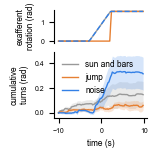

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(1.2, 1.4), height_ratios=(1,2))

pop_mean_snips = np.mean(mean_snips, axis=0)
pop_sem_snips  = np.std(mean_snips, axis=0) / np.sqrt(mean_snips.shape[0])

# visualize stimulus
ax[0].plot(snip_t, pop_mean_snips[0, 2, :], color=color_getter(1))
ax[0].plot(snip_t, pop_mean_snips[1, 2, :], color=color_getter(2))
ax[0].plot(snip_t, pop_mean_snips[2, 2, :], '--', color=color_getter(3))

# visualize turning
for i, label in enumerate(('sun and bars', 'jump', 'noise')):
    ax[1].fill_between(snip_t,
                       pop_mean_snips[i, 1, :]-pop_sem_snips[i, 1, :],
                       pop_mean_snips[i, 1, :]+pop_sem_snips[i, 1, :],
                       alpha=0.2, color=color_getter(i+1), lw=0)
    ax[1].plot(snip_t, pop_mean_snips[i, 1, :], color=color_getter(i+1),label=label)
ax[1].legend()
ax[0].set_ylabel('exafferent\nrotation (rad)')
ax[1].set_ylabel('cumulative\nturns (rad)')
ax[1].set_xlabel('time (s)')

toggle_spines(ax[0], 0,0,0,1)
toggle_spines(ax[1], 0,1,0,1)

plt.savefig('../svg/ed01_e.svg')
plt.show()

## Extended Data Fig. 5d (example of bump phase change compared to motor and exafferent visual components)
- Multiple-regress bump phase change by exogenous scene rotation and fish's turning 
- Regression is better than correlation for several reasons:
    - It allows us to estimate the gain
    - If fish swam in response to the noise rotation, and if its own estimate of how much it turned is bigger or smaller than what we estimate, the sign of correlation can be opposite

In [41]:
# loop through all recordings
for i, fish_data in enumerate(data):    
    for j, D in enumerate(fish_data):
        
        t_i = D['t_i']
        noise_start = D['slog'][-1]['t_start']
        is_noise = t_i>noise_start

        # limit time series to the noise epoch
        t_i = t_i[is_noise]
        upva      = np.unwrap(D['pva_theta'])[is_noise] # bump phase
        theta     = D['theta_i'][is_noise] # total theta
        cumftheta = D['cumftheta_i'][is_noise] # fish cumulative behavior
        extheta   = D['extheta_i'][is_noise] # exafference
        
        # define trigger points
        t_noise_rotation_midpoint = np.arange(noise_start, max(t_i), 30) + 27.5
        
        # make sure all the snippets are within the specific epoch
        t_noise_rotation_midpoint = np.asarray([t for t in t_noise_rotation_midpoint if noise_start+local_r_hw < t < max(t_i)-local_r_hw])
        
        # I am shifting the midpoints by 5 seconds, because "pre_subtraction" does the averaging of all time points before t=0
        # Because midpoints are at the center of the exafferent rotation, this makes pre-rotation baseline theta non-zero
        # This does not affect the fitting given that the model has the intercept term, but for the sake of aesthetics
        noise_pva_snip, snip_t   = cut_snip(upva,      t_i, t_noise_rotation_midpoint-5, local_r_hw-5, local_r_hw+5, subtract_pre=True)
        noise_theta_snip, _      = cut_snip(theta,     t_i, t_noise_rotation_midpoint-5, local_r_hw-5, local_r_hw+5, subtract_pre=True)
        noise_cumftheta_snip, _  = cut_snip(cumftheta, t_i, t_noise_rotation_midpoint-5, local_r_hw-5, local_r_hw+5, subtract_pre=True)
        noise_extheta_snip, _    = cut_snip(extheta,   t_i, t_noise_rotation_midpoint-5, local_r_hw-5, local_r_hw+5, subtract_pre=True)
        
        # register
        # Negative sign on fish cumulative theta, because turn to right moves the stimulus left
        data[i][j]['local_snips'] = (noise_pva_snip, noise_theta_snip, -noise_cumftheta_snip, noise_extheta_snip, snip_t)
        
        ## Do trial-wise ridge regression
        ridge_model = Ridge(alpha=1.0, fit_intercept=True, positive=True)
        coef = []
        r2 = []
        for k in range(len(t_noise_rotation_midpoint)):
            regressor = np.vstack((noise_cumftheta_snip[k, :], noise_extheta_snip[k, :])).T
            ridge_model.fit(regressor, noise_pva_snip[k, :])
            coef.append(ridge_model.coef_)
            r2.append(ridge_model.score(regressor, D['local_snips'][0][k, :]))
            
        sample_mean_coef = np.mean(np.asarray(coef), axis=0)
        sample_mean_r2 = np.mean(r2)

        ## Do bootstrap test
        bs_mean_coef = np.zeros((n_bootstrap, 2))
        bs_mean_r2 = np.zeros(n_bootstrap)
        for b in tqdm(range(n_bootstrap)):
            # roll by a random amount
            shift_amount = np.random.randint(np.sum(is_noise))
            rolled_pva = np.roll(upva, shift_amount)
            rolled_pva_snip, _ = cut_snip(rolled_pva, t_i, t_noise_rotation_midpoint, local_r_hw, local_r_hw, subtract_pre=True)
            
            # need to remove the local period containing the discontinuity due to the shuffling
            discontinuous_point = t_i[shift_amount]
            is_discontinuous = np.abs(t_noise_rotation_midpoint - discontinuous_point) < local_r_hw
            
            this_bs_coef = []
            this_bs_r2 = []
            for k in range(len(t_noise_rotation_midpoint)):
                if not is_discontinuous[k]:
                    regressor = np.vstack((noise_cumftheta_snip[k, :], noise_extheta_snip[k, :])).T
                    ridge_model.fit(regressor, rolled_pva_snip[k, :])
                    this_bs_coef.append(ridge_model.coef_)
                    this_bs_r2.append(ridge_model.score(regressor, rolled_pva_snip[k, :]))
            
            bs_mean_coef[b, :] = np.mean(np.asarray(this_bs_coef), axis=0)
            bs_mean_r2[b] = np.mean(this_bs_r2)
        
            coef_p = np.mean(bs_mean_coef > sample_mean_coef, axis=0)
            r2_p = np.mean(bs_mean_r2 > sample_mean_r2)
        
        data[i][j]['ridge_coef'] = coef
        data[i][j]['ridge_r2'] = r2
        data[i][j]['mean_coef'] = sample_mean_coef
        data[i][j]['mean_r2']   = sample_mean_r2
        data[i][j]['bs_coef']   = bs_mean_coef
        data[i][j]['bs_r2']     = bs_mean_r2
        data[i][j]['bs_coef_p'] = coef_p
        data[i][j]['bs_r2_p']   = r2_p


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.16it/s]


In [42]:
# take the same example as in the main fig
fid = 4
rid = 0
D = data[fid][rid]

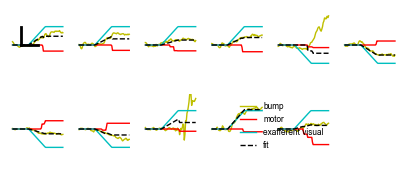

In [43]:
# visualize bump movements and associated visual/motor traces, for each trial
vmax=3
fig, ax = plt.subplots(2, 6, figsize=(5, 2))
ridge_model = Ridge(alpha=1.0, fit_intercept=True, positive=True)
for i in range(11):
    ax[i//6, i%6].plot(snip_t, D['local_snips'][0][i, :], 'y-', label='bump')  # bump
    ax[i//6, i%6].plot(snip_t, D['local_snips'][2][i, :], 'r-', label='motor')  # fish swimming
    ax[i//6, i%6].plot(snip_t, D['local_snips'][3][i, :], 'c-', label='exafferent visual')  # exogenous rotation
    
    # multilinear regression
    # with Ridge normalization (as weights on near-zero behaviors can blow up)
    ax[i//6, i%6].plot(snip_t, D['ridge_coef'][i][0]*D['local_snips'][2][i, :] + D['ridge_coef'][i][1]*D['local_snips'][3][i, :], 'k--', label='fit')  # exogenous rotation
    ax[i//6, i%6].set_ylim(-vmax, vmax)
    
ax[-1,-2].legend()
ax[0, 0].plot((0, 5), (0, 0), 'k-', lw=2)
ax[0, 0].plot((0, 0), (0, np.pi/2), 'k-', lw=2)

for axx in ax:
    for axxx in axx:
        toggle_spines(axxx, 0, 0, 0, 0)
        
plt.savefig('../svg/ed05_d.svg')
plt.show()

## Extended Data Fig. 5e (compare visual and motor coefficients from the regression analysis)

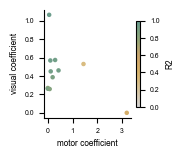

In [44]:
# For the same fish, show trial-wise gains with R2
fig, ax = plt.subplots(1,1,figsize=(1.4, 1.4))

sc = ax.scatter(np.asarray(D['ridge_coef'])[:, 0], np.asarray(D['ridge_coef'])[:, 1], c=np.asarray(D['ridge_r2']), vmin=0, vmax=1, s=5, cmap=cc.cm.CET_L10_r)

cb = plt.colorbar(sc, ax=ax, shrink=0.8, location='right')
ax.set_xlabel('motor coefficient')
ax.set_ylabel('visual coefficient')
cb.set_label('R2')
toggle_spines(ax, 0,1,0,1)

plt.savefig('../svg/ed05_e.svg')
plt.show()

## Extended Data Fig. 5f (visual motor coefficient comparison from regression analysis, for all fish)

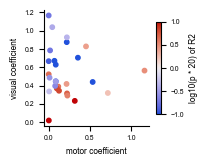

In [45]:
# for all fish, show trial-averaged visual or motor gains
# colored by bootstrap p-values of R2 -- scaled logarithmically such that significant ones look blue

fig, ax = plt.subplots(1,1,figsize=(1.7, 1.5))

mean_coef = np.vstack([np.vstack([D['mean_coef'] for D in fd]) for fd in data])
r2_p = np.hstack([np.hstack([D['bs_r2_p'] for D in fd]) for fd in data])

sc = ax.scatter(mean_coef[:, 0],mean_coef[:, 1], c=np.log10(20*(r2_p + 1/n_bootstrap)),
                vmin=-1, vmax=1, s=10, cmap=cc.cm.CET_D1)
cb = plt.colorbar(sc, ax=ax, shrink=0.8, location='right')
ax.set_xlabel('motor coefficient')
ax.set_ylabel('visual coefficient')
cb.set_label('log10(p * 20) of R2')

toggle_spines(ax, 0,1,0,1)

plt.savefig('../svg/ed05_f.svg')
plt.show()

## Extended Data Fig. 5g (cumulative distribution of R2 from the regression analysis)

In [46]:
# calculate cdf and do the KS test
p_x = np.linspace(0,1,1000)
p_cdf = np.asarray([np.mean(r2_p<x) for x in p_x])
ksp = kstest(r2_p, uniform.cdf)[1]

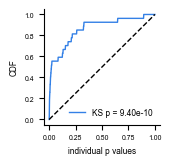

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))
ax.plot(p_x, p_cdf, color=color_getter(3), label='KS p = {:0.2e}'.format(ksp))
ax.plot(p_x, p_x, 'k--')
ax.legend()
ax.set_xlabel('individual p values')
ax.set_ylabel('CDF')
toggle_spines(ax, 0, 1, 0, 1)

plt.savefig('../svg/ed05_g.svg')
plt.show()